# 🧠🤖 Exemplo Completo de Treinamento de uma CNN

Este exemplo utiliza todos os conceitos que vimos nas últimas aulas:
- Processamento na GPU
- Data Augmentation
- Dropout
- Redes Pré-Treinadas

## Training with Custom CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style('darkgrid')


In [ ]:
import kagglehub

# Download latest version
ds_path = kagglehub.dataset_download("marquis03/bean-leaf-lesions-classification")
ds_path

'/kaggle/input/bean-leaf-lesions-classification'

In [ ]:
import os

os.listdir(ds_path)

['val.csv', 'classname.txt', 'val', 'train.csv', 'train']

In [ ]:
import pandas as pd

train_data = pd.read_csv(os.path.join(ds_path, 'train.csv')).to_numpy()
test_data = pd.read_csv(os.path.join(ds_path, 'val.csv')).to_numpy()

print("train_data.shape:", train_data.shape)
print("test_data.shape:", test_data.shape)
print("first rows:")
print(train_data[:5])

train_data.shape: (1034, 2)
test_data.shape: (133, 2)
first rows:
[['train/healthy/healthy_train.98.jpg' 0]
 ['train/healthy/healthy_train.148.jpg' 0]
 ['train/healthy/healthy_train.306.jpg' 0]
 ['train/healthy/healthy_train.305.jpg' 0]
 ['train/healthy/healthy_train.40.jpg' 0]]


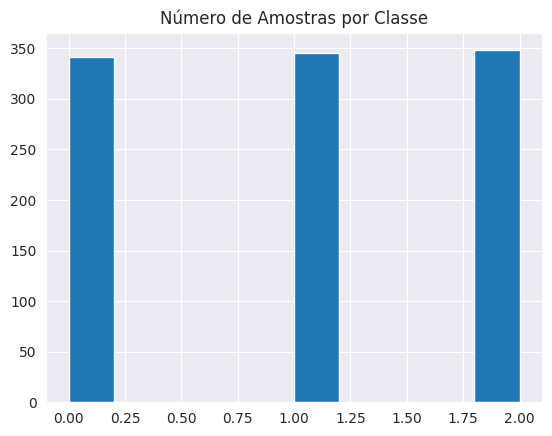

In [ ]:
plt.hist(train_data[:, 1])
plt.title("Número de Amostras por Classe")
plt.show()

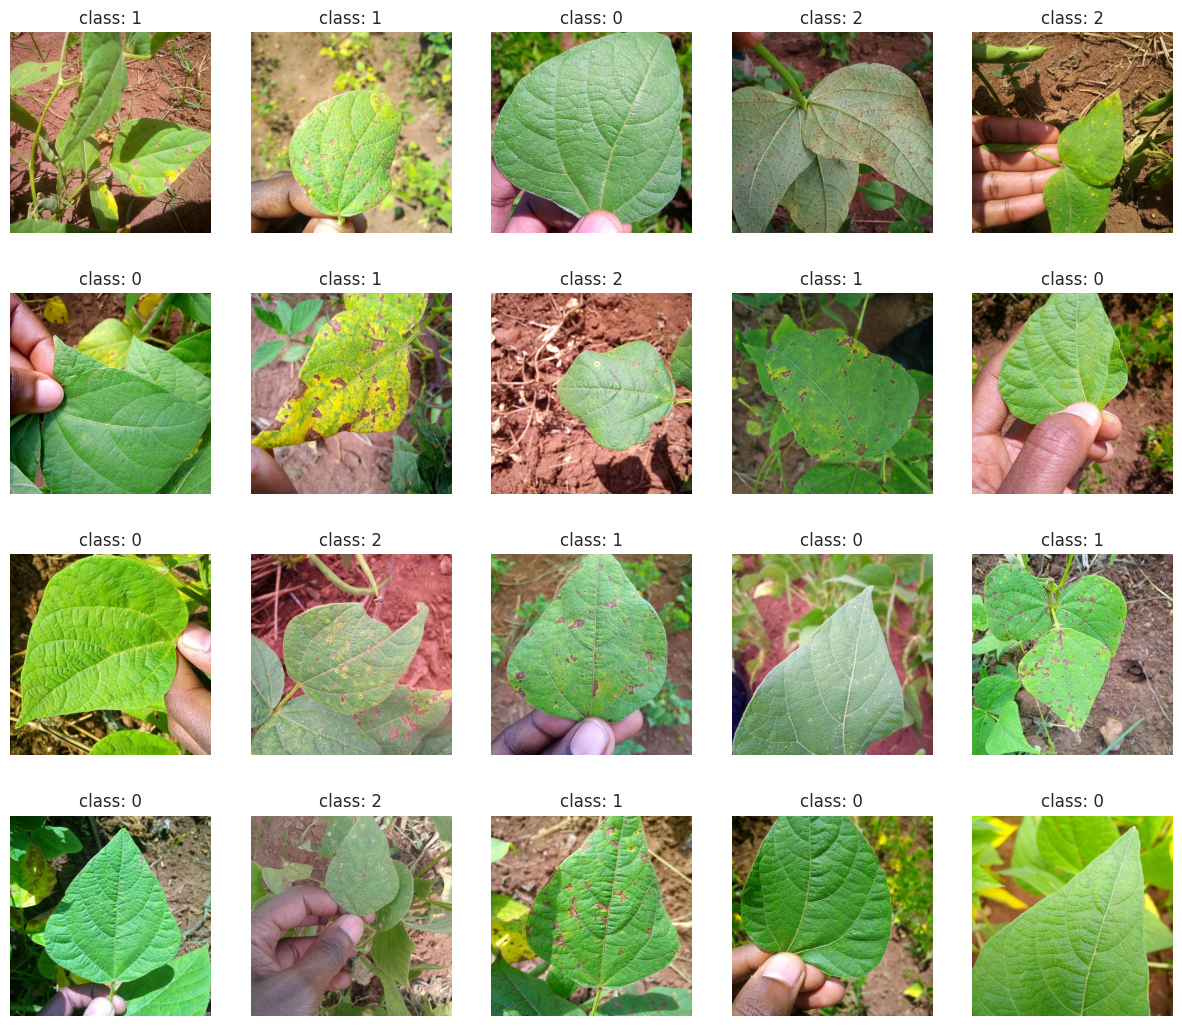

In [ ]:
from PIL import Image

plt.figure(figsize=(15, 13))
for idx in range(20):
  random_idx = np.random.randint(0, len(train_data)-1)
  path, label = train_data[random_idx, :]
  image = Image.open(os.path.join(ds_path, path))
  plt.subplot(4, 5, idx+1)
  plt.imshow(image)
  plt.grid(False)
  plt.axis('off')
  plt.title(f"class: {label}")

plt.show()


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

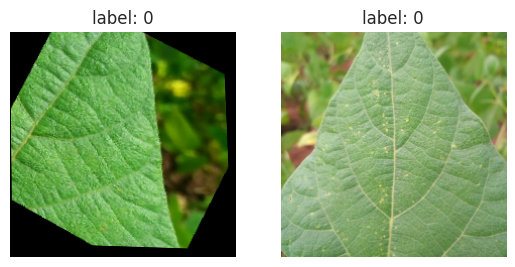

In [ ]:
from torchvision.transforms import v2

class BeanLeafDataset(Dataset):
  def __init__(self, data, transforms):
    self._data = data
    self._transforms = transforms

  def __len__(self):
    return len(self._data)

  def __getitem__(self, idx):
    img_path, label = self._data[idx, :]
    img = Image.open(os.path.join(ds_path, img_path))
    tensor = self._transforms(img)
    label = torch.tensor(label)
    return tensor, label


train_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=30),
    v2.RandomPerspective(0.2),
    # ...
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.Resize(224),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_ds = BeanLeafDataset(train_data, train_transform)
test_ds = BeanLeafDataset(test_data, test_transform)


# Exibe algumas imagens de teste
plt.subplot(1, 2, 1)
img_tensor, label = train_ds[0]
img = img_tensor.permute(1, 2, 0)
plt.imshow((img + 1) / 2)
plt.title(f'label: {label}')
plt.grid(False)
plt.axis('off')

plt.subplot(1, 2, 2)
img_tensor, label = test_ds[0]
img = img_tensor.permute(1, 2, 0)
plt.imshow((img + 1) / 2)
plt.title(f'label: {label}')
plt.grid(False)
plt.axis('off')


['val/healthy/healthy_val.25.jpg' 0]


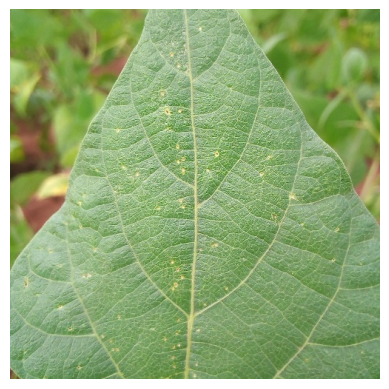

In [ ]:
plt.imshow(Image.open(os.path.join(ds_path, test_data[0][0])))
plt.grid(False)
plt.axis('off')
print(test_data[0])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=2)  # shuffling test just to have some variability in the qualitative analysis

In [ ]:

net = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, 5, stride=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, 5, stride=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),   # lembre-se do flatten!
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(64, 3)
)

net

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=128, out_features=64, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
net = net.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:

from tqdm.notebook import tqdm

def train_loop(train_loader, net):
  net.train()

  running_loss = 0.0
  all_preds = []
  all_labels = []

  for data in tqdm(train_loader):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      all_labels.extend(labels)

      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      all_preds.extend(list(np.argmax(outputs.cpu().detach().numpy(), axis=-1)))

      # print statistics
      running_loss += loss.cpu().item()

  return all_labels, all_preds, running_loss



In [ ]:

def eval_loop(loader, net):
  all_preds = []
  all_labels = []

  net.eval()

  with torch.no_grad():
    for data in tqdm(loader):
      images, labels = data
      all_labels.extend(labels)

      # calculate outputs by running images through the network
      images = images.to(device)
      outputs = net(images).cpu().numpy()
      all_preds.extend(list(np.argmax(outputs, axis=-1)))

  return all_labels, all_preds


In [ ]:
from sklearn.metrics import accuracy_score

history = []

for epoch in range(10):  # loop over the dataset multiple times
    true, pred, loss = train_loop(train_loader, net)
    train_acc = accuracy_score(true, pred)

    true, pred = eval_loop(test_loader, net)
    test_acc = accuracy_score(true, pred)

    history.append([loss, train_acc, test_acc])
    print(f"Epoch {epoch} Loss: {loss:.2f} Train acc: {train_acc:.2f} Test acc: {test_acc:.2f} ")



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 Loss: 18.00 Train acc: 0.44 Test acc: 0.64 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 Loss: 15.42 Train acc: 0.58 Test acc: 0.53 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 Loss: 15.52 Train acc: 0.58 Test acc: 0.64 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 Loss: 14.64 Train acc: 0.63 Test acc: 0.67 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 Loss: 14.21 Train acc: 0.64 Test acc: 0.65 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 Loss: 13.62 Train acc: 0.65 Test acc: 0.69 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 Loss: 12.94 Train acc: 0.65 Test acc: 0.71 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 Loss: 12.52 Train acc: 0.69 Test acc: 0.63 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 Loss: 11.96 Train acc: 0.70 Test acc: 0.71 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 Loss: 12.50 Train acc: 0.69 Test acc: 0.73 


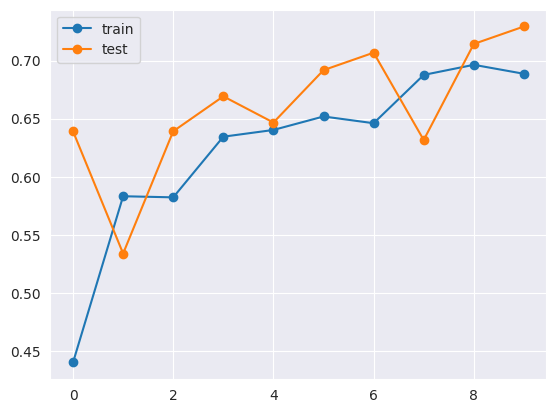

In [ ]:
history = np.array(history)
plt.plot(history[:, 1], '-o')
plt.plot(history[:, 2], '-o')
plt.legend(['train', 'test'])


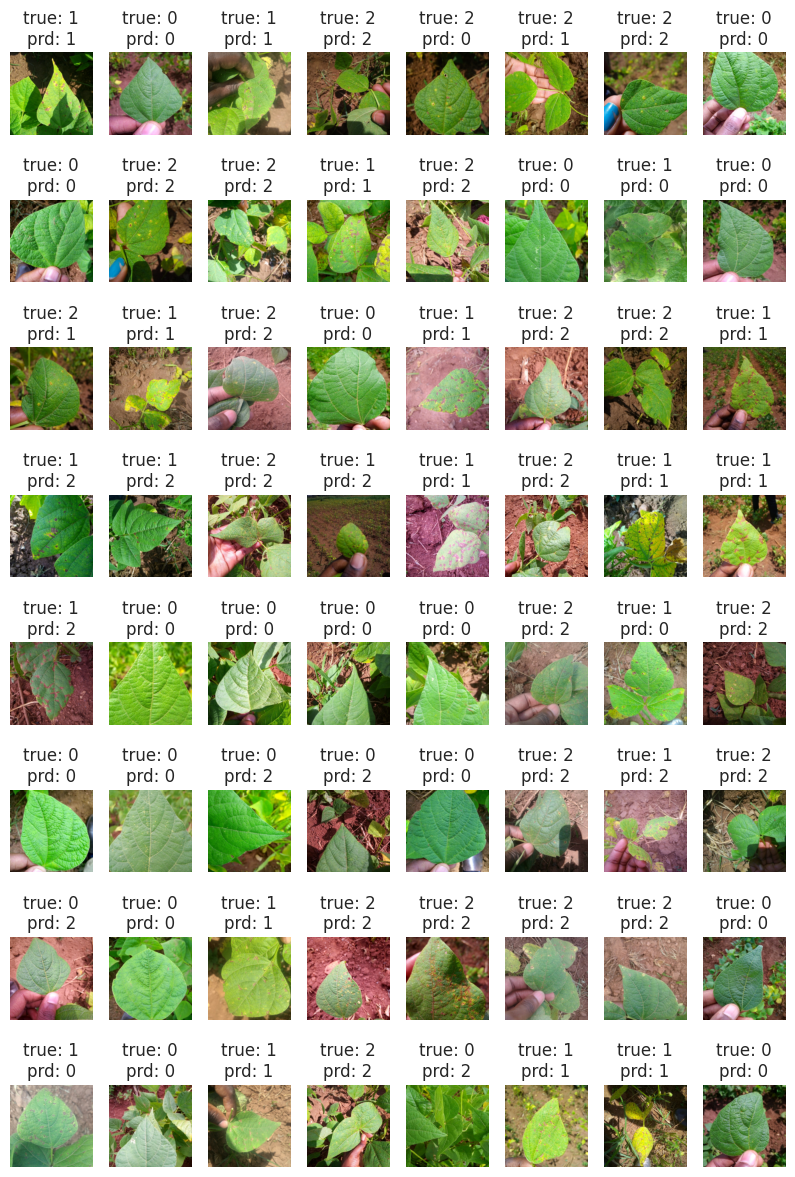

In [ ]:
def show_batch(images, labels, net=None):
    prd = None
    if net:
        with torch.no_grad():
            images_gpu = images.to(device)
            prd = net(images_gpu).cpu().numpy()
        # classe mais provavel por amostra
        prd = np.argmax(prd, axis=-1)

    n = len(images)
    grid_size = int(np.ceil(np.sqrt(n)))

    for idx in range(n):
        plt.subplot(grid_size, grid_size, idx + 1)
        img = images[idx].numpy()

        # muda do formato [channels, rows, cols] do torch para [rows, cols, channels]
        img = np.transpose(img, (1, 2, 0))

        img = (img + 1) / 2
        plt.imshow(img, cmap='gray')
        plt.grid(False)
        plt.axis('off')
        title = f'true: {labels[idx].numpy()}'
        if prd is not None:
            title += f'\nprd: {prd[idx]}'
        plt.title(title)

net.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

plt.close('all')
plt.figure(figsize=(10, 15))
show_batch(images, labels, net)
plt.show()

In [ ]:
true, pred = eval_loop(test_loader, net)

print(classification_report(true, pred))

  0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        44
           1       0.78      0.66      0.72        44
           2       0.65      0.73      0.69        45

    accuracy                           0.73       133
   macro avg       0.74      0.73      0.73       133
weighted avg       0.74      0.73      0.73       133



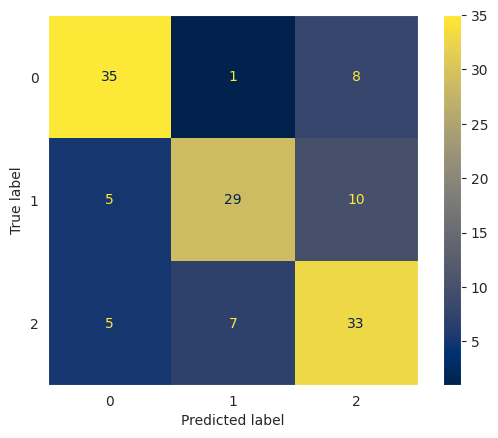

In [ ]:

cm = confusion_matrix(true, pred, labels=list(range(3)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(3)))
disp.plot(cmap='cividis')
plt.grid(False)
plt.show()


## Training using Pretrained Models

In [ ]:
from torchvision import models

net = models.resnet18(weights="IMAGENET1K_V1")
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# IMPORTANTE: VERIFICAR O TAMANHO DA IMAGEM DE ENTRADA EM QUE O MODELO FOI PRETREINADO!
# ISTO IMPACTA O TAMANHO DA ENTRADA PARA A CAMADA TOTALMENTE CONECTADA!
n_in = net.fc.in_features

# Substitui a camada de classificacao por uma nova
net.fc = nn.Linear(n_in, 3)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)


In [ ]:
from sklearn.metrics import accuracy_score

history = []

for epoch in range(10):  # loop over the dataset multiple times
    true, pred, loss = train_loop(train_loader, net)
    train_acc = accuracy_score(true, pred)

    true, pred = eval_loop(test_loader, net)
    test_acc = accuracy_score(true, pred)

    history.append([loss, train_acc, test_acc])
    print(f"Epoch {epoch} Loss: {loss:.2f} Train acc: {train_acc:.2f} Test acc: {test_acc:.2f} ")



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 Loss: 12.55 Train acc: 0.73 Test acc: 0.68 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 Loss: 6.12 Train acc: 0.86 Test acc: 0.92 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 Loss: 4.25 Train acc: 0.91 Test acc: 0.93 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 Loss: 3.70 Train acc: 0.92 Test acc: 0.92 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 Loss: 3.52 Train acc: 0.92 Test acc: 0.95 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 Loss: 3.68 Train acc: 0.93 Test acc: 0.98 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 Loss: 3.77 Train acc: 0.94 Test acc: 0.94 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 Loss: 4.43 Train acc: 0.92 Test acc: 0.87 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 Loss: 4.26 Train acc: 0.91 Test acc: 0.90 


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 Loss: 4.08 Train acc: 0.92 Test acc: 0.98 


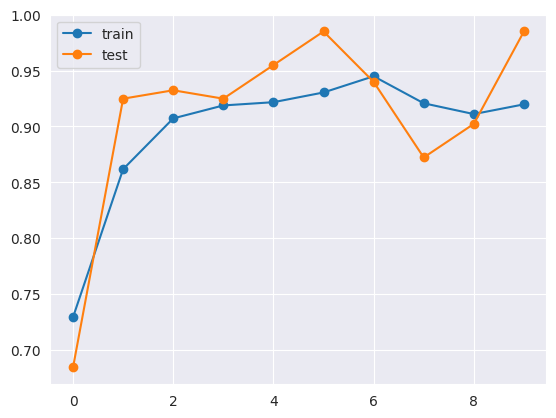

In [ ]:

history = np.array(history)
plt.plot(history[:, 1], '-o')
plt.plot(history[:, 2], '-o')
plt.legend(['train', 'test'])


  0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.98      1.00      0.99        44
           2       1.00      0.98      0.99        45

    accuracy                           0.98       133
   macro avg       0.99      0.99      0.98       133
weighted avg       0.99      0.98      0.98       133



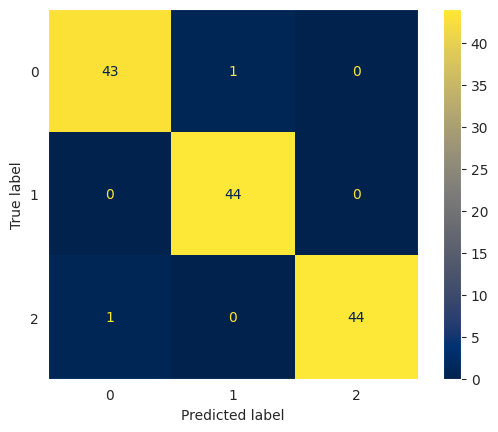

In [ ]:
true, pred = eval_loop(test_loader, net)

print(classification_report(true, pred))

cm = confusion_matrix(true, pred, labels=list(range(3)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(3)))
disp.plot(cmap='cividis')
plt.grid(False)
plt.show()
